# Cyber-Physical Systems Intelligent Maintenance

## Introduction

The goal of this challenge is to predict the remaining useful life of a machine based on the data collected from it. The data is collected from a machine in a factory. We will use multiple DL models such as CNN, LSTM and a hybrid model to predict the remaining useful life of the machine.

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import Sequential, models, layers
from keras.layers import Dropout, BatchNormalization, Dense
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

### FD001 Dataset

FD001 subset corresponds to High-Pressure Compressor (HPC) failure of the engine.

The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine). Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle. The columns in the dataset are: 

In [291]:
index_names = ["Engine", "Cycle"]
setting_names = ["Setting 1", "Setting 2", "Setting 3"]
sensor_names = [
    "(Fan Inlet Temperature) (◦R)",
    "(LPC Outlet Temperature) (◦R)",
    "(HPC Outlet Temperature) (◦R)",
    "(LPT Outlet Temperature) (◦R)",
    "(Fan Inlet Pressure) (psia)",
    "(Bypass-Duct Pressure) (psia)",
    "(HPC Outlet Pressure) (psia)",
    "(Physical Fan Speed) (rpm)",
    "(Physical Core Speed) (rpm)",
    "(Engine Pressure Ratio(P50/P2)",
    "(HPC Outlet Static Pressure) (psia)",
    "(Ratio of Fuel Flow to Ps30) (pps/psia)",
    "(Corrected Fan Speed) (rpm)",
    "(Corrected Core Speed) (rpm)",
    "(Bypass Ratio) ",
    "(Burner Fuel-Air Ratio)",
    "(Bleed Enthalpy)",
    "(Required Fan Speed)",
    "(Required Fan Conversion Speed)",
    "(High-Pressure Turbines Cool Air Flow)",
    "(Low-Pressure Turbines Cool Air Flow)",
]

col_names = index_names + setting_names + sensor_names
rul_col = ["RUL"]

In [292]:
DATA_DIR = "..\data\HybridLearningDataset\CMAPSSData"
TRAIN_FD001 = "train_FD001.txt"
TEST_FD001 = "test_FD001.txt"
RUL_FD001 = "RUL_FD001.txt"

TRAIN_DIR = os.path.join(DATA_DIR, TRAIN_FD001)
TEST_DIR = os.path.join(DATA_DIR, TEST_FD001)
RUL_DIR = os.path.join(DATA_DIR, RUL_FD001)

In [293]:
def load_data(file_path: str, col_names: list) -> pd.DataFrame:
    data = pd.read_csv(file_path, sep="\s+", header=None, names=col_names)
    print(f"Data loaded successfully from {file_path}")
    return data

In [294]:
df_train = load_data(TRAIN_DIR, col_names)
df_test = load_data(TEST_DIR, col_names)
df_rul = load_data(RUL_DIR, rul_col)
df_rul["Engine"] = df_rul.index + 1

Data loaded successfully from ..\data\HybridLearningDataset\CMAPSSData\train_FD001.txt
Data loaded successfully from ..\data\HybridLearningDataset\CMAPSSData\test_FD001.txt
Data loaded successfully from ..\data\HybridLearningDataset\CMAPSSData\RUL_FD001.txt


In [295]:
display(df_train.head())
display(df_test.head())
display(df_rul.head())

,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),(Bypass-Duct Pressure) (psia),(HPC Outlet Pressure) (psia),(Physical Fan Speed) (rpm),(Physical Core Speed) (rpm),(Engine Pressure Ratio(P50/P2),(HPC Outlet Static Pressure) (psia),(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),(Bypass-Duct Pressure) (psia),(HPC Outlet Pressure) (psia),(Physical Fan Speed) (rpm),(Physical Core Speed) (rpm),(Engine Pressure Ratio(P50/P2),(HPC Outlet Static Pressure) (psia),(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow)
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


,RUL,Engine
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [296]:
df_train.shape, df_test.shape, df_rul.shape

((20631, 26), (13096, 26), (100, 2))

In [297]:
df_train.loc[:, ["Engine", "Cycle"]].describe()

,Engine,Cycle
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [298]:
num_of_cycles_for_engines = df_train.groupby("Engine")["Cycle"].max()
num_of_cycles_for_engines

Engine
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: Cycle, Length: 100, dtype: int64

In [299]:
num_of_cycles_for_engines = df_test.groupby("Engine")["Cycle"].max()
num_of_cycles_for_engines

Engine
1       31
2       49
3      126
4      106
5       98
      ... 
96      97
97     134
98     121
99      97
100    198
Name: Cycle, Length: 100, dtype: int64

Text(0, 0.5, 'max_cycle')

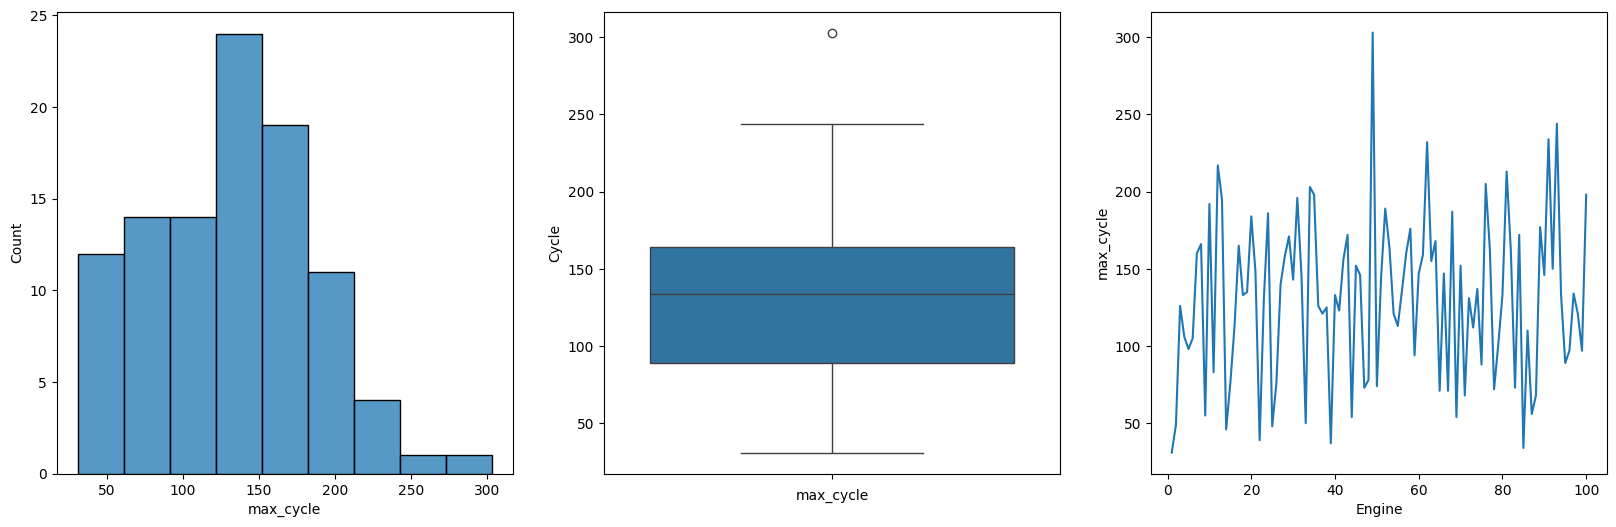

In [300]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(num_of_cycles_for_engines, kde=False, bins="fd", ax=ax[0])
ax[0].set_xlabel("max_cycle")

sns.boxplot(num_of_cycles_for_engines, ax=ax[1])
ax[1].set_xlabel("max_cycle")

num_of_cycles_for_engines.plot(ax=ax[2])
ax[2].set_xlabel("Engine")
ax[2].set_ylabel("max_cycle")

In [301]:
pd.DataFrame(num_of_cycles_for_engines).describe()

,Cycle
count,100.000000
mean,130.960000
std,53.593479
min,31.000000
25%,88.750000
50%,133.500000
75%,164.250000
max,303.000000


From above plots it can be inferred that most of the engines work for about 200 cycles before failing. Now we have to add the `RUL` column to the dataset which will be the remaining useful life of the engine. The `RUL` column will be calculated as follows:

- For each engine, the last cycle will be the cycle at which the engine fails.
- The `RUL` for each cycle will be the difference between the last cycle and the current cycle.

As for test data, the `RUL` column will be calculated as follows:

- For each engine, the last cycle will be the cycle at which data ends.
- The `RUL` for each cycle will be the difference between the last cycle and the current cycle plus the `RUL` of the last cycle, which comes from the `RUL.txt` file.

In [302]:
def add_remaining_useful_life(df: pd.DataFrame, cycles_after_last_cycle: pd.Series = None) -> pd.DataFrame:
    if cycles_after_last_cycle is not None:
        max_cycle = df.groupby("Engine")["Cycle"].transform("max")
        df = df.merge(cycles_after_last_cycle, on="Engine", how="left")
        df["RUL"] = df["RUL"] + (max_cycle - df["Cycle"])
    else:
        max_cycle = df.groupby("Engine")["Cycle"].transform("max")
        df["RUL"] = max_cycle - df["Cycle"]
    return df

In [303]:
df_train = add_remaining_useful_life(df_train)
df_train.head()

,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),(Bypass-Duct Pressure) (psia),(HPC Outlet Pressure) (psia),(Physical Fan Speed) (rpm),(Physical Core Speed) (rpm),(Engine Pressure Ratio(P50/P2),(HPC Outlet Static Pressure) (psia),(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow),RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [304]:
df_test = add_remaining_useful_life(df_test, df_rul)
df_test.head()

,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),(Bypass-Duct Pressure) (psia),(HPC Outlet Pressure) (psia),(Physical Fan Speed) (rpm),(Physical Core Speed) (rpm),(Engine Pressure Ratio(P50/P2),(HPC Outlet Static Pressure) (psia),(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow),RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


<Axes: >

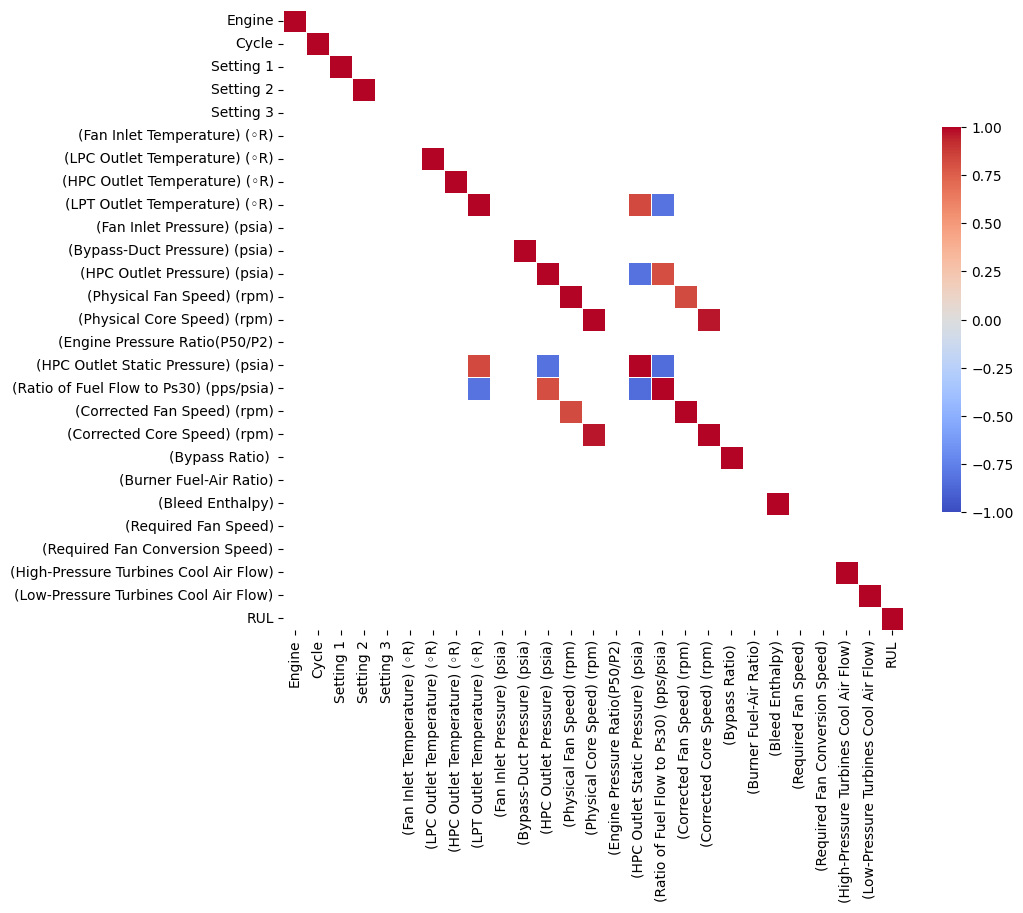

In [307]:
corr = df_train.corr()
threshold = 0.8
mask = corr.where((abs(corr) >= threshold)).isna()

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",
    vmax=1,
    vmin=-1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)